<a href="https://colab.research.google.com/github/lamirabbasl/colortogray_picture/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

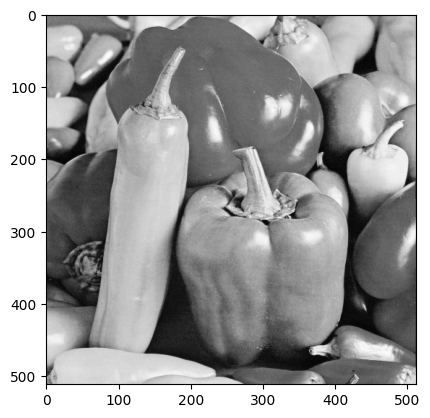

run time: 0.821108341217041


In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time

img = cv.imread('peppers.tiff')
img2 = cv.cvtColor(img, cv.COLOR_BGR2RGB)

start = time.time()

# Convert image to grayscale
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Display grayscale image
plt.figure()
plt.imshow(gray_img, cmap='gray')
plt.show()

print("run time: " + str(time.time() - start))

# Save RGB data as CSV format with delimiter=""
np.savetxt(fname='blue_peppers.csv', delimiter=",", X=img2[:, :, 2].reshape(-1, 1))
np.savetxt(fname='green_peppers.csv', delimiter=",", X=img2[:, :, 1].reshape(-1, 1))
np.savetxt(fname='red_peppers.csv', delimiter=",", X=img2[:, :, 0].reshape(-1, 1))


In [16]:
pip install nvcc4jupyter

In [17]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [18]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <chrono>

__global__ void ctg(char *red, char *blue, char *green, char *grayImage, int width, int height) {
    int Col = threadIdx.x + blockIdx.x * blockDim.x;
    int Row = threadIdx.y + blockIdx.y * blockDim.y;

    if (Col < width && Row < height) {
        int grayOffset = Row * width + Col;
        unsigned char r = red[grayOffset];
        unsigned char g = green[grayOffset];
        unsigned char b = blue[grayOffset];
        grayImage[grayOffset] = 0.21f * r + 0.71f * g + 0.07f * b;
    }
}

int main() {
    FILE *fp;
    char blue[512*512];
    char *d_blue;

    char red[512*512];
    char *d_red;

    char green[512*512];
    char *d_green;

    char grayImage[512*512];
    char *d_grayImage;

    const int height = 512;
    const int width = 512;
    const int PCount = height * width;
    const int MemoryNeed = PCount * sizeof(char);

    cudaMalloc((void**)&d_blue, MemoryNeed);
    cudaMalloc((void**)&d_green, MemoryNeed);
    cudaMalloc((void**)&d_red, MemoryNeed);
    cudaMalloc((void**)&d_grayImage, MemoryNeed);

    fp = fopen("blue_peppers.csv", "r");
    fread(blue, sizeof(char), PCount, fp);
    fclose(fp);

    fp = fopen("green_peppers.csv", "r");
    fread(green, sizeof(char), PCount, fp);
    fclose(fp);

    fp = fopen("red_peppers.csv", "r");
    fread(red, sizeof(char), PCount, fp);
    fclose(fp);

    cudaMemcpy(d_blue, blue, MemoryNeed, cudaMemcpyHostToDevice);
    cudaMemcpy(d_green, green, MemoryNeed, cudaMemcpyHostToDevice);
    cudaMemcpy(d_red, red, MemoryNeed, cudaMemcpyHostToDevice);

    dim3 dimGrid(512 / 32 + 1, 512 / 32 + 1, 1);
    dim3 dimBlock(32, 32, 1);

    auto start = std::chrono::high_resolution_clock::now();
    ctg<<<dimGrid, dimBlock>>>(d_red, d_blue, d_green, d_grayImage, height, width);
    cudaDeviceSynchronize();
    auto end = std::chrono::high_resolution_clock::now();
    double time_taken = std::chrono::duration_cast<std::chrono::nanoseconds>(end - start).count();
    time_taken *= 1e-9;
    printf("Time taken: %lf seconds\n", time_taken);

    cudaMemcpy(grayImage, d_grayImage, MemoryNeed, cudaMemcpyDeviceToHost);

    return 0;
}


Time taken: 0.000239 seconds

